# House Prices Advanced Regression Techniques 3

In this part, we will try to use CatBoostRegressor following an online lad. We do no analysis, just use the whole data to train the model.

## Cat Boost Regressor

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor

from catboost import CatBoostRegressor

In [11]:
continuous_pip = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

discrete_pip = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder()
)

preprocess_pip = make_column_transformer(
    (continuous_pip, make_column_selector(dtype_include=np.number)),
    (discrete_pip, make_column_selector(dtype_include=object)),
    verbose_feature_names_out=False,
)

cat_boost_regressor = CatBoostRegressor(random_state=42, silent=True, allow_writing_files=False)
log_level_regressor = TransformedTargetRegressor(
    cat_boost_regressor,
    func=np.log1p,
    inverse_func=np.expm1,
)

model_pipeline = make_pipeline(
    preprocess_pip,
    log_level_regressor
)

In [12]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
model_pipeline.fit(df_train.drop(columns=["Id", "SalePrice"]), df_train["SalePrice"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002DDCD8D1DB0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002DDCD940DF0>)],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=<catboost.core.CatBoostRegressor object at 0x000002DDCD942200>))])

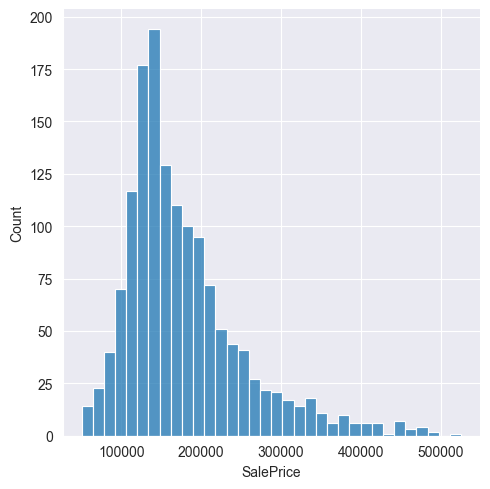

In [13]:
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
df_test["SalePrice"] = model_pipeline.predict(df_test.drop(columns=["Id"]))

sns.displot(df_test["SalePrice"])

In [14]:
df_test["Id"] = df_test["Id"].astype(int)
df_test[["Id", "SalePrice"]].to_csv("../input/house-prices-advanced-regression-techniques/submission/cat-boost-v1.1.csv", index=False)

Score: 0.12656

Pretty amazing since it's better a lot.

## Append Post Processing

To improve the score, we will try rounding and rounding to nearest 50.

In [15]:
def rounding(sale_price: pd.Series) -> pd.Series:
    return sale_price.round()

def round_nearest_50(sale_price: pd.Series) ->  pd.Series:
    return (sale_price / 50).round() * 50

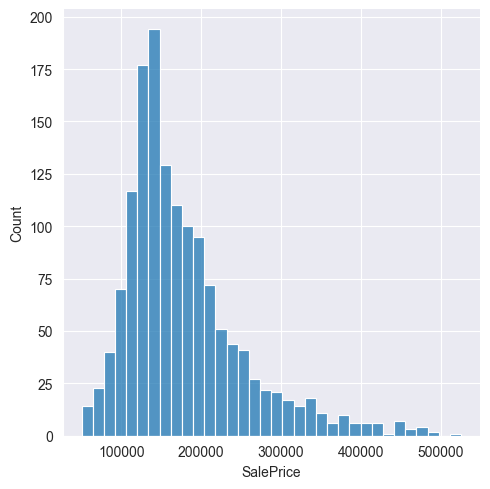

In [16]:
df_test["SalePrice"] = rounding(df_test["SalePrice"])
df_test["Id"] = df_test["Id"].astype(int)
df_test[["Id", "SalePrice"]].to_csv("../input/house-prices-advanced-regression-techniques/submission/cat-boost-v2.1.csv", index=False)

sns.displot(df_test["SalePrice"])

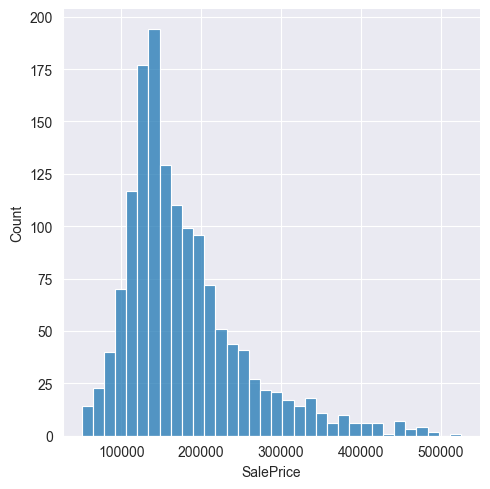

In [17]:
df_test["SalePrice"] = round_nearest_50(df_test["SalePrice"])
df_test["Id"] = df_test["Id"].astype(int)
df_test[["Id", "SalePrice"]].to_csv("../input/house-prices-advanced-regression-techniques/submission/cat-boost-v3.1.csv", index=False)

sns.displot(df_test["SalePrice"])

Score: 0.12656

Make no difference.

## Try selecting 30 most important features

In [52]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
cat_boost = CatBoostRegressor(random_state=42, silent=True, allow_writing_files=False)

df_preprocess = pd.DataFrame(
    preprocess_pip.fit_transform(df_train.drop(columns=["Id", "SalePrice"])),
    columns=preprocess_pip.get_feature_names_out()
)

selection_result = cat_boost.select_features(
    df_preprocess,
    np.log1p(df_train["SalePrice"]),
    features_for_select=df_preprocess.columns,
    num_features_to_select=30,
    logging_level="Silent",
)

In [53]:
selected_features = selection_result["selected_features_names"]

model_pipeline_v2 = make_pipeline(
    preprocess_pip,
    log_level_regressor
)

df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

model_pipeline_v2.fit(df_train[selected_features], df_train["SalePrice"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002DDCD8D1DB0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002DDCD940DF0>)],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=<catboost.core.CatBoostRegressor object at 0x000002DDCD942200>))])

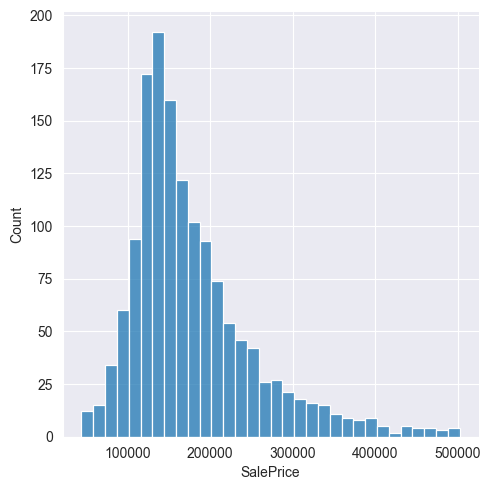

In [54]:
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
df_test["SalePrice"] = model_pipeline_v2.predict(df_test[selected_features])
df_test["SalePrice"] = round_nearest_50(df_test["SalePrice"])

sns.displot(df_test["SalePrice"])

In [56]:
df_test["Id"] = df_test["Id"].astype(int)
df_test[["Id", "SalePrice"]].to_csv("../input/house-prices-advanced-regression-techniques/submission/cat-boost-v3.3.csv", index=False)

Score: 0.12993

Turn out this is worse idea.